In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Import Dependancies

In [2]:
#!/usr/bin/env python3.11
!python --version

import mesa
print(f"mesa version: {mesa.__version__}")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

DEBUGVOCAB = False
DEBUGSTEP = False

Python 3.12.6
mesa version: 3.1.5


# The Naming Game

text

In [3]:
#ideas for own unique approach:
# multiple objects and graph how time until vocab convergence changes?
# different lengths of words and graph difference there?
# limit amount of symbols for words?
# 

Create Random Word

In [4]:
from random import choice
from string import ascii_uppercase

def create_word(min_length=6, max_length=10):
    new_word = ''.join(choice(ascii_uppercase) for _ in range(np.random.randint(min_length, max_length)))
    return new_word

Create Agent

In [5]:
class NamingGameAgent(mesa.Agent):
    def __init__(self, model, m_objects=1):
        super().__init__(model)
        self._m_objects = m_objects
        self.vocabulary = dict()

    def choose_object_and_word(self):
        #chosen from range will always choose 0 index object value, so m_objects = 1 -> chosen object is 0
        chosen_object = np.random.randint(0, self._m_objects)
        
        if chosen_object in self.vocabulary.keys():
            chosen_word = random.choice(self.vocabulary[chosen_object])
        else:
            chosen_word = create_word()
            self.vocabulary[chosen_object] = [chosen_word]
        return chosen_object, chosen_word

    def recognize_word(self, chosen_object, chosen_word):
        if chosen_object not in self.vocabulary.keys():
            return False
        if chosen_word in self.vocabulary[chosen_object]:
            return True
        else:
            return False

    def agree_to_word(self, chosen_object, chosen_word):
        self.vocabulary[chosen_object] = [chosen_word]

    def add_word(self, chosen_object, chosen_word):
        if chosen_object not in self.vocabulary.keys():
            self.vocabulary[chosen_object] = [chosen_word]
        else:
            self.vocabulary[chosen_object].append(chosen_word)

    def retrieve_vocabulary(self):
        return [f"Object: {key} - words: {value}" for key, value in self.vocabulary.items()]
    
    def word_amount(self):
        return sum([len(word_list) for word_list in self.vocabulary.values()])

Class for computing successrate

In [6]:
class SuccessRate(list):
    def __init__(self, maxlen=10):
        super().__init__()
        self._maxlen = maxlen
    
    def add(self, value):
        if type(value) != int:
            raise TypeError("Only integers are allowed in SuccessRate")
        if len(self) >= self._maxlen:
            self.pop(0)
        self.append(value)
    
    def get_rate(self):
        return sum(self)/len(self) if self else 0

    def get_values(self):
        return list(self)

Create Model

In [7]:
from mesa.datacollection import DataCollector

class NamingGameModel(mesa.Model):
    def __init__(self, N=100, m_objects=1, seed=None):
        super().__init__(seed=seed)
        self.max_words = 0
        self.max_time = 0
        self.conv_time = 0
        self.num_agents = N
        self.success_rate = SuccessRate(maxlen=200)
        self.datacollector = DataCollector(
            agent_reporters={"Vocabulary": NamingGameAgent.retrieve_vocabulary, 
                             "Word_amount": NamingGameAgent.word_amount},
            model_reporters={"Success_rate": self.success_rate.get_rate,
                             #"Success_rate_values": self.success_rate.get_values,
                             "Total_word_amount": "total_word_amount",
                             "Total_unique_word_amount": "total_unique_word_amount"}
        )
        self.m_objects = m_objects
        NamingGameAgent.create_agents(model=self, n=N, m_objects=m_objects)

    def update_max_words(self):
        if self.max_words < self.total_word_amount:
            self.max_words = self.total_word_amount
            self.max_time = self.steps
    
    def check_convergence(self):
        if self.total_unique_word_amount == self.m_objects:
            self.conv_time = self.steps
    
    def step(self):
        if self.steps % 100 == 0:
            self.datacollector.collect(self)
            self.update_max_words()
            self.check_convergence()
        speaker, hearer = random.sample(self.agents, 2)
        if self.steps % 100 == 0 and DEBUGVOCAB:
            if speaker.word_amount() != 0:
                print(speaker.word_amount())
                print(speaker.retrieve_vocabulary())
        chosen_object, chosen_word = speaker.choose_object_and_word()
        if hearer.recognize_word(chosen_object, chosen_word):
            self.success_rate.add(1)
            speaker.agree_to_word(chosen_object, chosen_word)
            hearer.agree_to_word(chosen_object, chosen_word)
        else:
            self.success_rate.add(0)
            hearer.add_word(chosen_object, chosen_word)

    @property
    def total_word_amount(self):
        return sum([agent.word_amount() for agent in self.agents])

    @property
    def total_unique_word_amount(self):
        unique_words = set()
        for agent in self.agents:
            for word_list in agent.vocabulary.values():
                unique_words.update(word_list)
        return len(unique_words)


Run Model function

In [8]:
def run_model(N, M, t, iteration):
    print(f"Starting model iteration: {iteration}")
    model = NamingGameModel(N, M)
    for i in range(t):
        if i % int(t/10) == 0 and DEBUGSTEP:
            print(f"iter: {iteration}, step: {i}")
            
        model.step()

    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return agent_data, model_data, model.max_time, model.conv_time

Run model configuration for figure 2

In [9]:
N = 1000
M = 1
t = 100000

RUNS = 30
single_run1 = np.random.randint(0, int(RUNS/4)+1)
single_run2 = min(int(RUNS-1), int(RUNS - single_run1))
print(single_run1)
print(single_run2)

model_df = pd.DataFrame()
single_run1_agent_data, single_run1_model_data = pd.DataFrame(), pd.DataFrame()
single_run2_agent_data, single_run2_model_data = pd.DataFrame(), pd.DataFrame()
for i in range(RUNS):
    agent_data, model_data, _, _ = run_model(N=N, M=M, t=t, iteration=i+1)
    if i == single_run1:
        single_run1_agent_data = agent_data
        single_run1_model_data = model_data
    if i == single_run2:
        single_run2_agent_data = agent_data
        single_run2_model_data = model_data
    
    if model_df.empty:
        model_df = model_data
    else:
        model_df = (model_df + model_data) / 2

2
28
Starting model iteration: 1
Starting model iteration: 2
Starting model iteration: 3
Starting model iteration: 4
Starting model iteration: 5
Starting model iteration: 6
Starting model iteration: 7
Starting model iteration: 8
Starting model iteration: 9
Starting model iteration: 10
Starting model iteration: 11
Starting model iteration: 12
Starting model iteration: 13
Starting model iteration: 14
Starting model iteration: 15
Starting model iteration: 16
Starting model iteration: 17
Starting model iteration: 18
Starting model iteration: 19
Starting model iteration: 20
Starting model iteration: 21
Starting model iteration: 22
Starting model iteration: 23
Starting model iteration: 24
Starting model iteration: 25
Starting model iteration: 26
Starting model iteration: 27
Starting model iteration: 28
Starting model iteration: 29
Starting model iteration: 30


Datacollection Dataframes

In [10]:
single_run1_agent_data

Vocabulary  Word_amount
Step   AgentID                                                
100    1          [Object: 0 - words: ['FWGSPM']]            1
       2        [Object: 0 - words: ['PBHHLFSD']]            1
       3                                       []            0
       4        [Object: 0 - words: ['RMZMBGGH']]            1
       5                                       []            0
...                                           ...          ...
100000 996        [Object: 0 - words: ['SEMYLG']]            1
       997        [Object: 0 - words: ['SEMYLG']]            1
       998        [Object: 0 - words: ['SEMYLG']]            1
       999        [Object: 0 - words: ['SEMYLG']]            1
       1000       [Object: 0 - words: ['SEMYLG']]            1

[1000000 rows x 2 columns]

In [11]:
model_df

,Success_rate,Total_word_amount,Total_unique_word_amount
0,0.000000e+00,189.601148,90.601148
1,0.000000e+00,358.362215,159.362215
2,1.192093e-09,522.602472,223.602473
3,1.192093e-09,674.492450,275.492451
4,3.906251e-04,817.311748,318.389874
...,...,...,...
995,1.000000e+00,1000.000000,1.000000
996,1.000000e+00,1000.000000,1.000000
997,1.000000e+00,1000.000000,1.000000
998,1.000000e+00,1000.000000,1.000000


Create Graphs and Figures

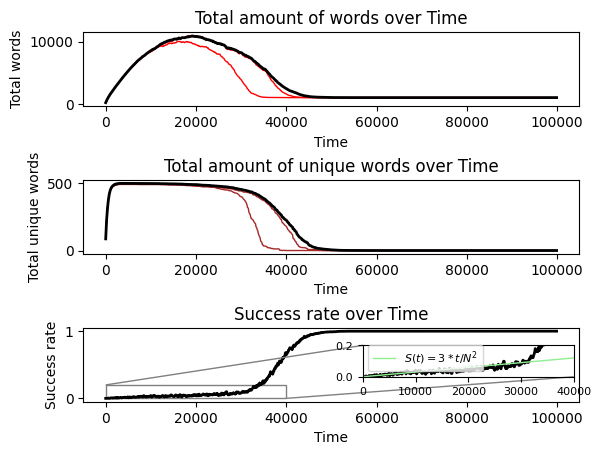

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

model_df["scaled_index"] = model_df.index * 100
single_run1_model_data["scaled_index"] = single_run1_model_data.index * 100
single_run2_model_data["scaled_index"] = single_run2_model_data.index * 100
fig, axs = plt.subplots(nrows=3)

#figure showing all total words over time
g = sns.lineplot(data=single_run1_model_data[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="red", linewidth=1)
g = sns.lineplot(data=single_run2_model_data[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="red", linewidth=1)
g = sns.lineplot(data=model_df[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="black", linewidth=2)
g.set(title="Total amount of words over Time", ylabel="Total words", xlabel="Time")

#figure showing all unique words over time
g = sns.lineplot(data=single_run1_model_data[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="brown", linewidth=1)
g = sns.lineplot(data=single_run2_model_data[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="brown", linewidth=1)
g = sns.lineplot(data=model_df[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="black", linewidth=2)
g.set(title="Total amount of unique words over Time", ylabel="Total unique words", xlabel="Time")

#figure showing all successful interactions over time
g = sns.lineplot(data=model_df[["Success_rate", "scaled_index"]], x="scaled_index", y="Success_rate", 
                 ax=axs[2], color="black", linewidth=2)
g.set(title="Success rate over Time", ylabel="Success rate", xlabel="Time")

#smaller figure showing succesful interactions over time with overlaid s(t)=3t/N^2
ax_inset = inset_axes(axs[2], width="85%", height="85%", loc='center left',
                      bbox_to_anchor=(0.55, 0.3, 0.5, 0.5), bbox_transform=axs[2].transAxes)

x = model_df["scaled_index"]
inset_y = model_df["Success_rate"]
y = 3 * x / N**2
ax_inset.plot(x, inset_y, 
              color="black", linewidth=2)
ax_inset.plot(x, y, 
              color='lightgreen', label=r'$S(t) = 3*t/{N^2}$', linewidth=1)

#zoom
ax_inset.set_xlim(0, 40000)
ax_inset.set_ylim(0, 0.2)
ax_inset.tick_params(axis='both', labelsize=8)
ax_inset.legend(fontsize=8)

mark_inset(axs[2], ax_inset, loc1=2, loc2=4, fc="none", ec="0.5") #TODO ask if this is too messy

plt.subplots_adjust(hspace=1)

Run model configuration for figure 3

In [ ]:
n_log = np.logspace(1, 6, 10, base=10, dtype=int)
n_st = [50, 100, 500, 1000, 5000, 10000, 50000, 100000]
M = 1
t = 100000

model_lin_df = pd.DataFrame()
model_log_df = pd.DataFrame()
max_time_list = []
conv_time_list = []

for n in n_log:
    _, model_data, max_time, conv_time  = run_model(N=n, M=M, t=t, iteration=n)
    max_time_list.append(max_time)
    conv_time_list.append(conv_time)

    if model_lin_df.empty:
        model_lin_df = model_data
    else:
        model_lin_df = (model_lin_df + model_data) / 2

for n in n_st:
    _, model_data, _, _ = run_model(N=n, M=M, t=t, iteration=n)

    if model_log_df.empty:
        model_log_df = model_data
    else:
        model_log_df = (model_log_df + model_data) / 2

/mnt/c/Users/Fabia/Documents/Studium/CMSS/CMSS_Exercises/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:302: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y).astype(dtype, copy=False)
/mnt/c/Users/Fabia/Documents/Studium/CMSS/CMSS_Exercises/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:302: RuntimeWarning: invalid value encountered in cast
  return _nx.power(base, y).astype(dtype, copy=False)


Starting model iteration: 10000000000
